In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d iarunava/imdb-movie-reviews-dataset

Saving kaggle.json to kaggle.json
 97% 110M/114M [00:00<00:00, 126MB/s] 
100% 114M/114M [00:00<00:00, 138MB/s]


In [4]:
!ls
!unzip imdb-movie-reviews-dataset.zip

aclImdb  imdb-movie-reviews-dataset.zip  kaggle.json  sample_data
Archive:  imdb-movie-reviews-dataset.zip
replace aclImdb/test/labeledBow.feat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
!ls aclImdb

imdbEr.txt  imdb.vocab	README	test  train


import libiraries 

In [0]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout





  



loading data 

In [0]:
path = ''
######### load data ############

def shuffle(X, y):
    perm = np.random.permutation(len(X))
    X = X[perm]
    y = y[perm]
    return X, y
  
  
def load_imdb_dataset(path):
    imdb_path = os.path.join(path, 'aclImdb')

    # Load the dataset
    train_texts = []
    train_labels = []
    test_texts = []
    test_labels = []
    for dset in ['train', 'test']:
        for cat in ['pos', 'neg']:
            dset_path = os.path.join(imdb_path, dset, cat)
            for fname in sorted(os.listdir(dset_path)):
                if fname.endswith('.txt'):
                    with open(os.path.join(dset_path, fname)) as f:
                        if dset == 'train': train_texts.append(f.read())
                        else: test_texts.append(f.read())
                    label = 0 if cat == 'neg' else 1
                    if dset == 'train': train_labels.append(label)
                    else: test_labels.append(label)

    # Converting to np.array
    train_texts = np.array(train_texts)
    train_labels = np.array(train_labels)
    test_texts = np.array(test_texts)
    test_labels = np.array(test_labels)

    # Shuffle the dataset
    train_texts, train_labels = shuffle(train_texts, train_labels)
    test_texts, test_labels = shuffle(test_texts, test_labels)

    # Return the dataset
    return train_texts, train_labels, test_texts, test_labels
  
  
  ########### end load data ##################

view data 

In [7]:
trX, trY, ttX, ttY = load_imdb_dataset(path)

print ('Train samples shape :', trX.shape)
print ('Train labels shape  :', trY.shape)
print ('Test samples shape  :', ttX.shape)
print ('Test labels shape   :', ttY.shape)

Train samples shape : (25000,)
Train labels shape  : (25000,)
Test samples shape  : (25000,)
Test labels shape   : (25000,)


verifying

In [8]:
uniq_classes_arr, counts = np.unique(trY, return_counts=True)

print ('Unique classes :', uniq_classes_arr)
print ('Number of unique classes : ', len(uniq_classes_arr))

for _class in uniq_classes_arr:
    print ('Counts for class ', uniq_classes_arr[_class], ' : ', counts[_class])

Unique classes : [0 1]
Number of unique classes :  2
Counts for class  0  :  12500
Counts for class  1  :  12500


average number of words per sample

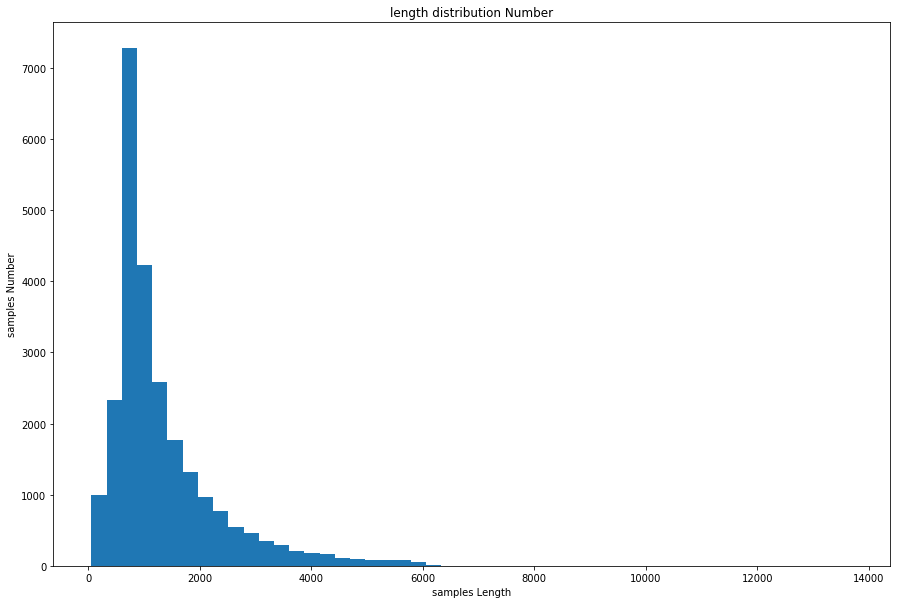

In [9]:
plt.figure(figsize=(15, 10))
plt.hist([len(sample) for sample in list(trX)], 50)
plt.xlabel('samples Length')
plt.ylabel('samples Number')
plt.title('length distribution Number')
plt.show()

plot a frequency distribution

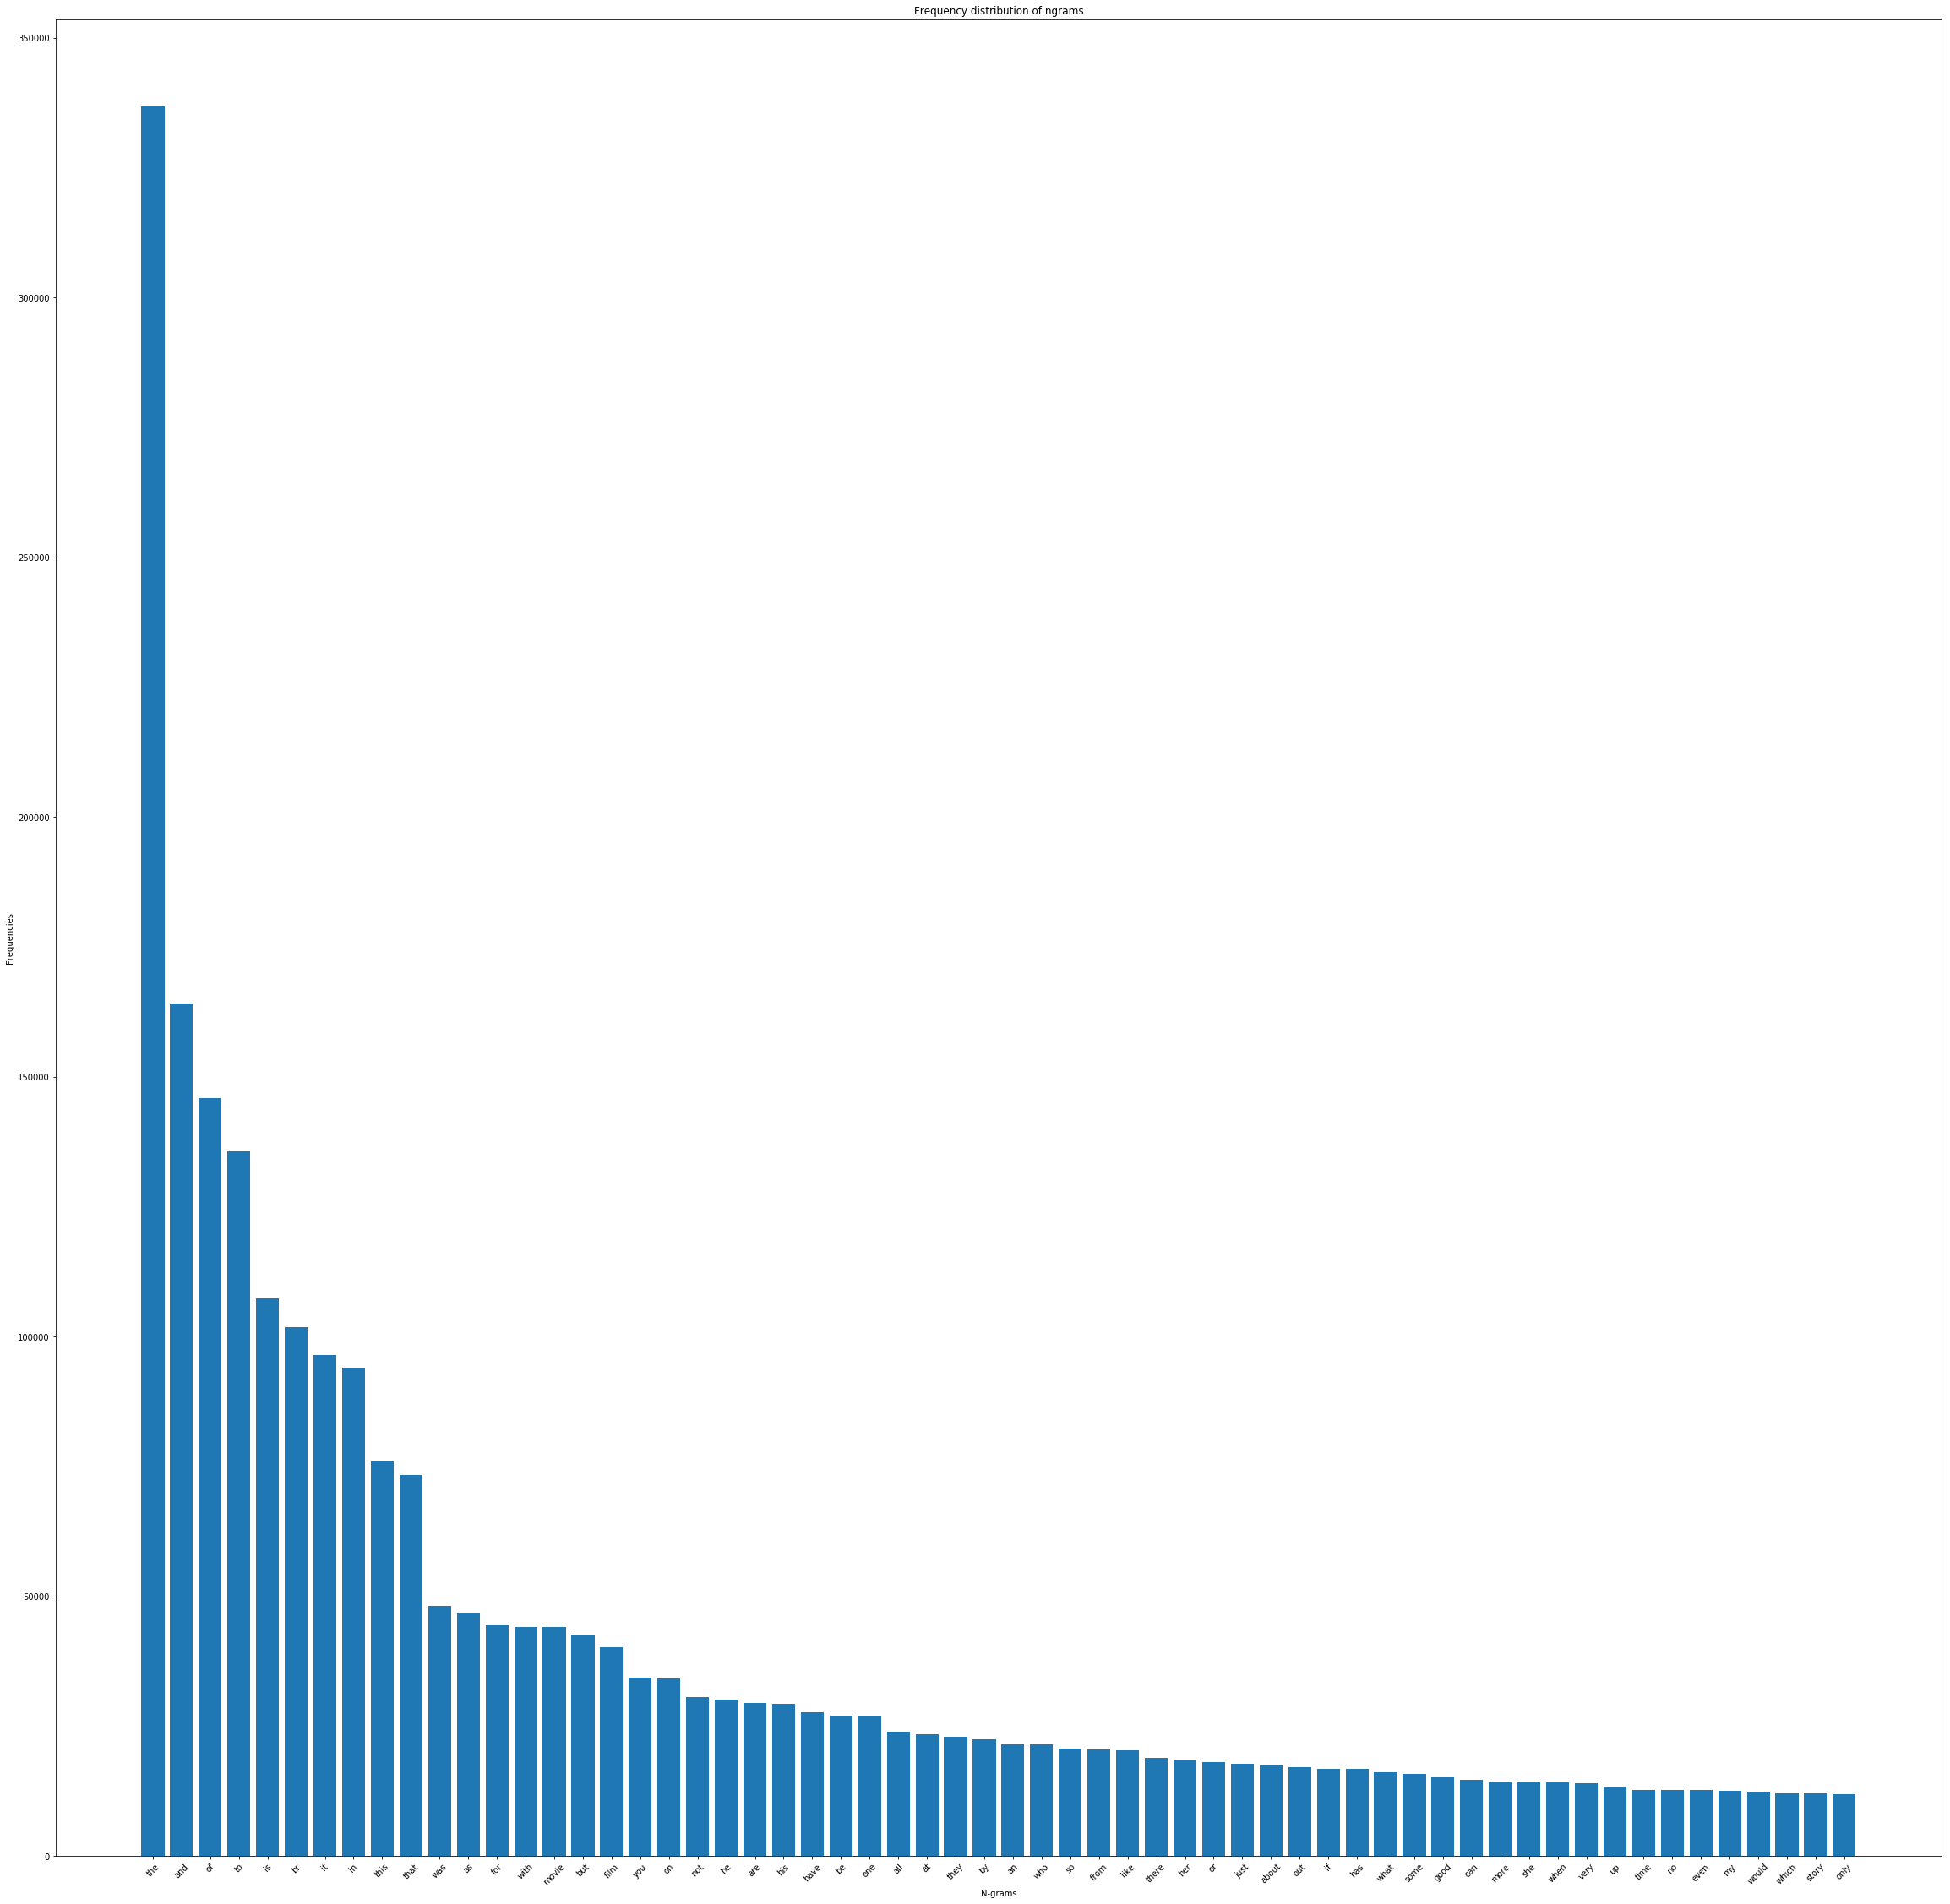

In [10]:
key_words_args = {
    'ngram_range' : (1, 1),
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : 'word'
}

vectorizer = CountVectorizer(**key_words_args)
vectoriz_texts = vectorizer.fit_transform(list(trX))
all_ngrams = vectorizer.get_feature_names()
num_ngrams = min(60, len(all_ngrams))
all_counts = vectoriz_texts.sum(axis=0).tolist()[0]
all_ngrams, all_counts = zip(*[(n, c) for c, n in sorted(zip(all_counts, all_ngrams), reverse=True)])
ngrams = all_ngrams[:num_ngrams]
counts = all_counts[:num_ngrams]
idx = np.arange(num_ngrams)
plt.figure(figsize=(40, 40))
plt.bar(idx, counts, width=0.8)
plt.xlabel('N-grams')
plt.ylabel('Frequencies')
plt.title('Frequency distribution of ngrams')
plt.xticks(idx, ngrams, rotation=45)
plt.show()

prepare the data

In [0]:
NGRAM_RANGE = (1, 2)
TOP_K = 20000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2

def ngram_vectorize(train_texts, train_labels, val_texts):
    key_words_args = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
    }
    
    tfidf_vectorizer = TfidfVectorizer(**key_words_args)
    x_train = tfidf_vectorizer.fit_transform(train_texts)
    x_val = tfidf_vectorizer.transform(val_texts)
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val

create the model using the Keras API from tensorflow

In [0]:
def generate_model(layers, units, dropout_rate, input_shape, num_classes):
    op_units, op_activation = (1,  'sigmoid')
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))
    
    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))
        
    model.add(Dense(units=op_units, activation=op_activation))
    return model

train the model

In [0]:
def train_ngram_model(data, learning_rate=1e-3, epochs=1000, batch_size=128, layers=2, units=64, 
                      dropout_rate=0.2,patience=2): 
    
    num_classes = 2 
    trX, trY, ttX, ttY = data
    loss = 'binary_crossentropy'
    x_train, x_val = ngram_vectorize(trX, trY, ttX)
    model = generate_model(layers, units=units, dropout_rate=dropout_rate,
                      input_shape=x_train.shape[1:], num_classes=num_classes)
    
    optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])
    
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
    history = model.fit(x_train, trY, epochs=epochs, validation_data=(x_val, ttY), 
                        verbose=2, batch_size=batch_size, callbacks=callbacks)
    
    history = history.history
    val_acc = history['val_acc'][-1]
    val_loss = history['val_loss'][-1]
    print ('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=val_acc, loss=val_loss))
    
    # Save model
    model.save('model' + str(val_acc) + '_' + str(loss) + '.h5')
    return val_acc, val_loss

call train_ngram_model_function

In [0]:
results = train_ngram_model((trX, trY, ttX, ttY),layers=10,patience=5, dropout_rate=0.1,learning_rate=1e-3)
print ('===========================================================================================')
print ('With lr=1e-3 | val_acc={results[0]} | val_loss={results[1]}'.format(results=results))
print ('===========================================================================================')

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1577: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)
